# Time-series forecasting the SP 500

Summary: This notebook will use a few simple neural networks to predict the future price of the SP500.  Using a simple model, the accuracy of our price prediction could only be improved by ~1% relative to the baseline.  (The baseline used is the previous day's closing price.)  Price prediction, such as for stocks, is extremely difficult based upon the [efficent market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis).  The purpose, therefore, of this notebook is a demonstration of timeseries forecasting using machine learning.  I will show predictions from data going to June 2022.  I will also show a machine learning model could not predict Black Monday, when the SP500 fell by 20% in a single day.

Outline of the notebook:

    1. Problem Statement
    2. Data Source
    3. Evaluation Metrics
    4. Data Analysis
    5. Modeling Data and Results
    6. Conclusions


## 1. Problem Statement

Use a few simple neural networks to predict the price of the SP500.

## 2. Data

Data for the SP500 was collected from VFINX (Vanguard's SP500 mutual fund).  The data sourse was [Yahoo Finance](https://finance.yahoo.com/quote/VFINX/).  All price predictions are based on the closing price.

## 3. Evaluation Metrics

Using the previous day's closing price as our prediction baseline, we will attempt to see if machine learning can have better accuracy.

## 4. Data Analysis

In [1]:
import pandas as pd

"""
Note: for the location of the data used, please refer to the data folder of this project
"""

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/VFINX Data/VFINX price history.csv",
                 parse_dates=["Date"],
                 index_col = ["Date"])
print(df.describe())
print(df.head())


               Open          High           Low         Close     Adj Close  \
count  10712.000000  10712.000000  10712.000000  10712.000000  10712.000000   
mean     108.818196    108.818196    108.818196    108.818196     88.387983   
std       90.951513     90.951513     90.951513     90.951513     92.304776   
min       13.160000     13.160000     13.160000     13.160000      4.410861   
25%       33.820000     33.820000     33.820000     33.820000     16.895686   
50%       99.150002     99.150002     99.150002     99.150002     68.933506   
75%      133.975002    133.975002    133.975002    133.975002    103.682308   
max      442.670013    442.670013    442.670013    442.670013    441.334442   

        Volume  
count  10712.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0  
             Open   High    Low  Close  Adj Close  Volume
Date                                                     
1980-01-02  14.34  

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10712 entries, 1980-01-02 to 2022-06-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10712 non-null  float64
 1   High       10712 non-null  float64
 2   Low        10712 non-null  float64
 3   Close      10712 non-null  float64
 4   Adj Close  10712 non-null  float64
 5   Volume     10712 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 585.8 KB


In [3]:
# Number of datapoints
len(df)

10712

In [4]:
# Use closing price to build forecasting model
sp500_prices = pd.DataFrame(df["Close"]).rename(columns={"Close": "Price"})
sp500_prices.head()

,Price
Date,
1980-01-02,14.34
1980-01-03,14.27
1980-01-04,14.45
1980-01-07,14.49
1980-01-08,14.78


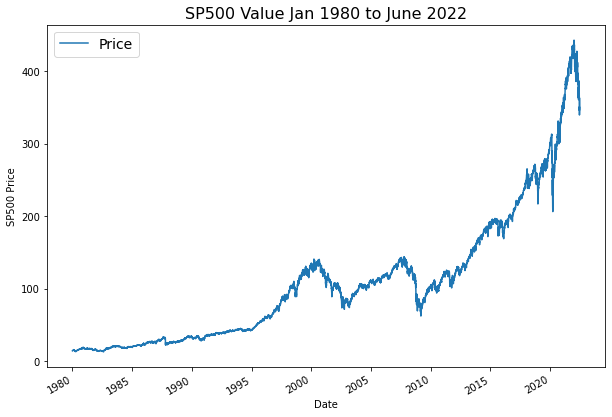

In [5]:
import matplotlib.pyplot as plt
sp500_prices.plot(figsize=(10, 7))
plt.ylabel("SP500 Price")
plt.title("SP500 Value Jan 1980 to June 2022", fontsize=16)
plt.legend(fontsize=14);

In [6]:
# Importing and formatting data
import csv
from datetime import datetime

timesteps = []
sp500_price = []
with open("/content/drive/MyDrive/Colab Notebooks/VFINX Data/VFINX price history.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip line 1
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates 
    sp500_price.append(float(line[1])) # get the closing price as float

# View first 5 of each
timesteps[:5], sp500_price[:5]

([datetime.datetime(1980, 1, 2, 0, 0),
  datetime.datetime(1980, 1, 3, 0, 0),
  datetime.datetime(1980, 1, 4, 0, 0),
  datetime.datetime(1980, 1, 7, 0, 0),
  datetime.datetime(1980, 1, 8, 0, 0)],
 [14.34, 14.27, 14.45, 14.49, 14.78])

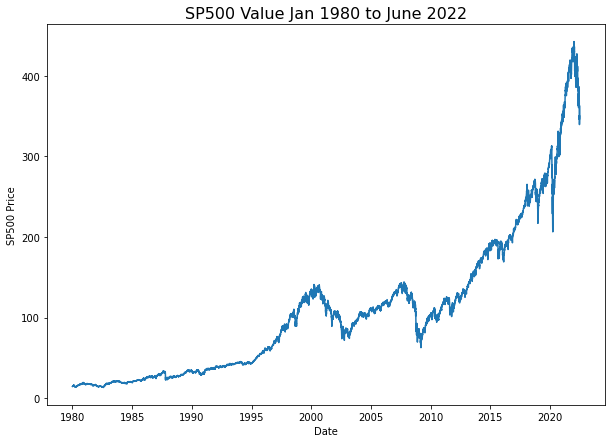

In [7]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, sp500_price)
plt.title("SP500 Value Jan 1980 to June 2022", fontsize=16)
plt.xlabel("Date")
plt.ylabel("SP500 Price");

In [8]:
# Create date array
timesteps = sp500_prices.index.to_numpy()
prices = sp500_prices["Price"].to_numpy()

timesteps[:5], prices[:5]

(array(['1980-01-02T00:00:00.000000000', '1980-01-03T00:00:00.000000000',
        '1980-01-04T00:00:00.000000000', '1980-01-07T00:00:00.000000000',
        '1980-01-08T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([14.34, 14.27, 14.45, 14.49, 14.78]))

In [9]:
# Create train/test splits for the data

from sklearn.model_selection import train_test_split 


# Create train and test splits the right way for time series data
split_size = int(0.9 * len(prices)) # 90% train, 10% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(9640, 1072, 9640, 1072)

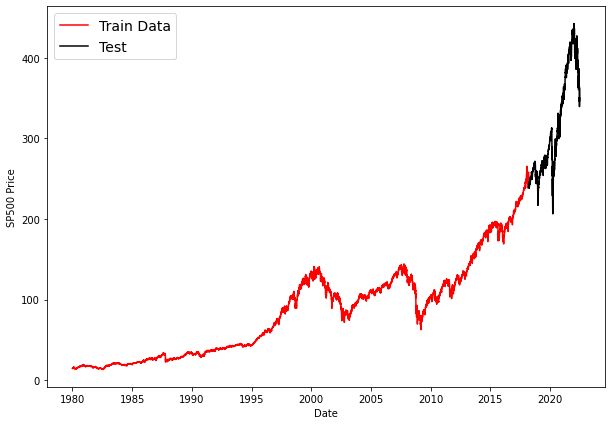

In [10]:
# Plot train/test splits
plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train, label="Train Data",color="red")
plt.plot(X_test, y_test, label="Test",color="black")
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.legend(fontsize=14);


## Baseline: Simple model using previous closing price

In [11]:
baseline = y_test[:-1] # previous day's close for the predicted value
baseline[:5], baseline[-5:] # View frist 5 and last 5

(array([238.910004, 245.389999, 241.149994, 240.490005, 243.809998]),
 array([339.609985, 340.369995, 348.709991, 348.26001 , 351.600006]))

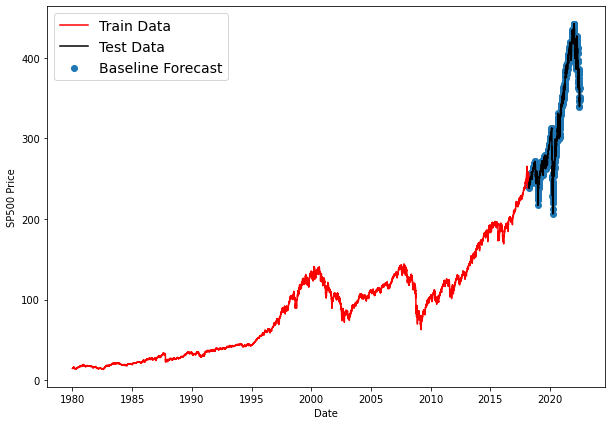

In [12]:
# Baseline forecast

plt.figure(figsize=(10, 7))
plt.plot(X_train, y_train, label="Train Data",color="red")
plt.plot(X_test, y_test, label="Test Data",color="black")
plt.scatter(X_test[1:], y_test[1:], label="Baseline Forecast")
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price");

Text(0.5, 1.0, 'SP500 Test Data vs Baseline Forecast')

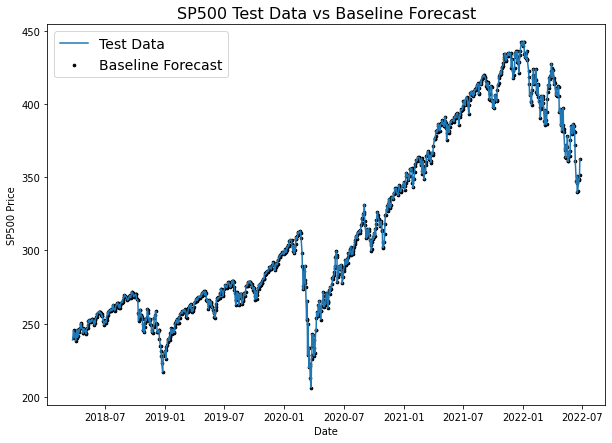

In [36]:
plt.figure(figsize=(10, 7))
plt.plot(X_test, y_test, label="Test Data")
plt.scatter(X_test[1:], y_test[1:], label="Baseline Forecast", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price");
plt.title("SP500 Test Data vs Baseline Forecast", fontsize=16)


In [14]:
import tensorflow as tf

# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of baseline forecast 
  mae_baseline_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_baseline_no_season

In [15]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred) # puts and emphasis on outliers (all errors get squared)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [16]:
baseline_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=baseline)
baseline_results

{'mae': 2.714659,
 'mape': 0.87824583,
 'mase': 1.001298,
 'mse': 16.610561,
 'rmse': 4.075606}

## Windowing the data

In [17]:
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 5  # use a previous week's worth of values for a day's prediction

In [18]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=1):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6] -> Output: ([1, 2, 3, 4, 5], [6])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [19]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


In [20]:
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [21]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10707, 10707)

In [22]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [14.34 14.27 14.45 14.49 14.78] -> Label: [14.8]
Window: [14.27 14.45 14.49 14.78 14.8 ] -> Label: [14.91]
Window: [14.45 14.49 14.78 14.8  14.91] -> Label: [14.91]


In [23]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]}")

Window: [345.929993 350.98999  339.609985 340.369995 348.709991] -> Label: [348.26001]
Window: [350.98999  339.609985 340.369995 348.709991 348.26001 ] -> Label: [351.600006]
Window: [339.609985 340.369995 348.709991 348.26001  351.600006] -> Label: [362.350006]


Turning windows into training and test datasets

In [24]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.1):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [25]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9636, 1071, 9636, 1071)

In [26]:
train_windows[:5], train_labels[:5]

(array([[14.34, 14.27, 14.45, 14.49, 14.78],
        [14.27, 14.45, 14.49, 14.78, 14.8 ],
        [14.45, 14.49, 14.78, 14.8 , 14.91],
        [14.49, 14.78, 14.8 , 14.91, 14.91],
        [14.78, 14.8 , 14.91, 14.91, 14.98]]), array([[14.8 ],
        [14.91],
        [14.91],
        [14.98],
        [15.08]]))

In [27]:
# Check to see if same (accounting for horizon and window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

False

### Model checkpoint function

In [28]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## 5. Modeling Data and Results

## Model 1: Dense model (window = 5, horizon = 1)

In [29]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(1)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 5 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model

Epoch 1/100
76/76 [==============================] - 2s 12ms/step - loss: 10.9280 - mae: 10.9280 - val_loss: 3.7858 - val_mae: 3.7858
Epoch 2/100
76/76 [==============================] - 1s 9ms/step - loss: 0.8247 - mae: 0.8247 - val_loss: 3.3614 - val_mae: 3.3614
Epoch 3/100
76/76 [==============================] - 0s 2ms/step - loss: 0.8329 - mae: 0.8329 - val_loss: 3.4552 - val_mae: 3.4552
Epoch 4/100
76/76 [==============================] - 1s 9ms/step - loss: 0.8154 - mae: 0.8154 - val_loss: 3.3084 - val_mae: 3.3084
Epoch 5/100
76/76 [==============================] - 0s 3ms/step - loss: 0.8117 - mae: 0.8117 - val_loss: 3.3543 - val_mae: 3.3543
Epoch 6/100
76/76 [==============================] - 0s 2ms/step - loss: 0.8218 - mae: 0.8218 - val_loss: 3.5054 - val_mae: 3.5054
Epoch 7/100
76/76 [==============================] - 0s 2ms/step - loss: 0.8093 - mae: 0.8093 - val_loss: 3.7321 - val_mae: 3.7321
Epoch 8/100
76/76 [==============================] - 1s 9ms/step - loss: 0.7972 

In [30]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 2.7494 - mae: 2.7494


[2.749424457550049, 2.749424457550049]

In [31]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 2ms/step - loss: 2.6941 - mae: 2.6941


[2.694136619567871, 2.694136619567871]

In [32]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [33]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(1071, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([240.21288, 244.65543, 242.40575, 240.59288, 243.68967, 239.6323 ,
        240.9612 , 244.21956, 245.79509, 241.704  ], dtype=float32)>)

In [34]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # reduce to right shape
                                 y_pred=model_1_preds)
model_1_results

{'mae': 2.694136,
 'mape': 0.86888254,
 'mase': 0.9937281,
 'mse': 16.308317,
 'rmse': 4.038356}

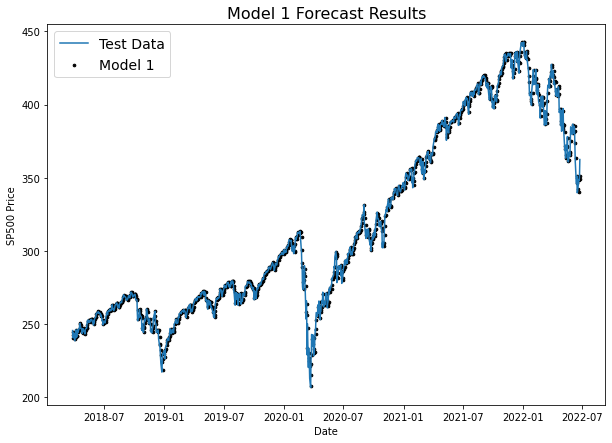

In [48]:
# Plotting model 1 results
plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_1_preds, label="Model 1", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 1 Forecast Results", fontsize=16);

## Model 2: Dense (window = 10, horizon = 1)

In [38]:
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 10 # use 2x weeks worth of data for the next prediction

In [39]:
# Make windowed data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10702, 10702)

In [40]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9631, 1071, 9631, 1071)

In [41]:
tf.random.set_seed(1)

# Create model (same model as model 1 but data input will be different)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # need to predict horizon number of steps into the future
], name="model_2_dense")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [42]:
# Evaluate model 2
model_2.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 3ms/step - loss: 2.8436


2.843644618988037

In [43]:
# Load in best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 2.7620


2.761967182159424

In [44]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [45]:
# Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), # remove 1 dimension of test labels
                                 y_pred=model_2_preds)
model_2_results

{'mae': 2.7619674,
 'mape': 0.8885084,
 'mase': 1.0187477,
 'mse': 16.76901,
 'rmse': 4.0949984}

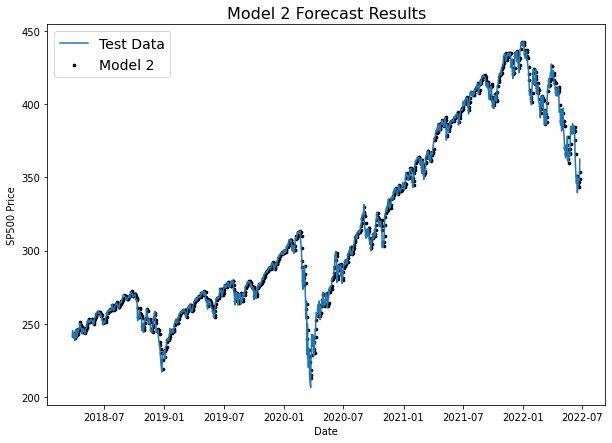

In [47]:
# Plot Model 2 Results

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_2_preds, label="Model 2", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 2 Forecast Results", fontsize=16);

##Model 3: Dense with window of 15, horizon = 5

In [49]:
HORIZON = 5 # predict a week ahead
WINDOW_SIZE = 15 # use 3 weeks of previous data

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10693, 10693)

In [50]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.1)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9623, 1070, 9623, 1070)

In [51]:
tf.random.set_seed(1)

# Create model (same as model_1 except with different data input size)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [52]:
#ow did our model with a larger window size and horizon go?
model_3.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 4.7969


4.796865940093994

In [53]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 4.6904


4.690443992614746

In [54]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [55]:
# The predictions are going to be 5 steps at a time (this is the HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

In [56]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
X_test[-len(test_windows):]model_3_results

{'mae': 4.6904435,
 'mape': 1.518309,
 'mase': 1.7318398,
 'mse': 50.17802,
 'rmse': 5.30653}

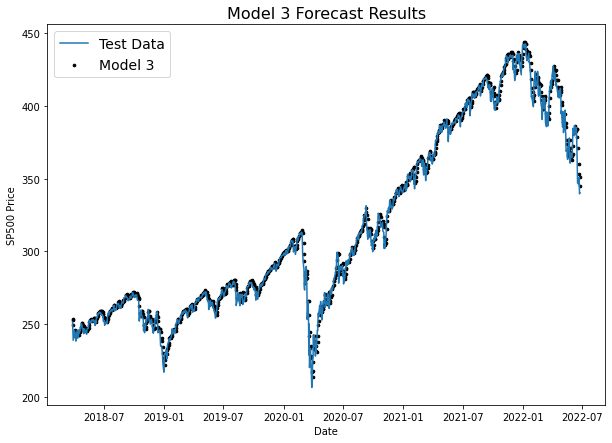

In [59]:
# Plot Model 3 Results

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], tf.reduce_mean(model_3_preds, axis=1), label="Model 3", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 3 Forecast Results", fontsize=16);

## Model 4: Conv1D

In [60]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 5 # use previous week worth of data

In [61]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(10707, 10707)

In [62]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(9636, 1071, 9636, 1071)

In [63]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(5,)

In [64]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (5,)
Expanded shape: (5, 1)
Original values with expanded shape:
 [[14.34]
 [14.27]
 [14.45]
 [14.49]
 [14.78]]


In [65]:
tf.random.set_seed(1)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [66]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 5)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            3328      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 3,457
Trainable params: 3,457
Non-trainable params: 0
_________________________________________________________________


In [67]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 1ms/step - loss: 2.7557


2.7557008266448975

In [68]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)

# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 2.7557008,
 'mape': 0.88641274,
 'mase': 1.0164362,
 'mse': 16.753819,
 'rmse': 4.093143}

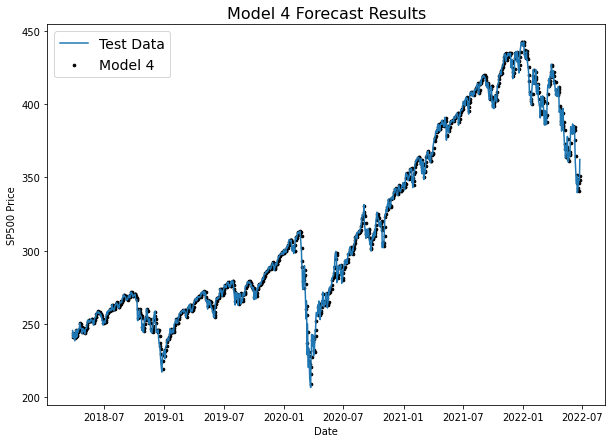

In [70]:
# Plot Model 4 Results

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_4_preds, label="Model 4", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 4 Forecast Results", fontsize=16);

## Model 5: RNN (LSTM)

In [71]:
tf.random.set_seed(1)

# LSTM model w/ the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=False,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets


In [72]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

34/34 [==============================] - 0s 2ms/step - loss: 2.7979


2.7979273796081543

In [73]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)

# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 2.7979267,
 'mape': 0.89594775,
 'mase': 1.0320112,
 'mse': 17.368196,
 'rmse': 4.1675167}

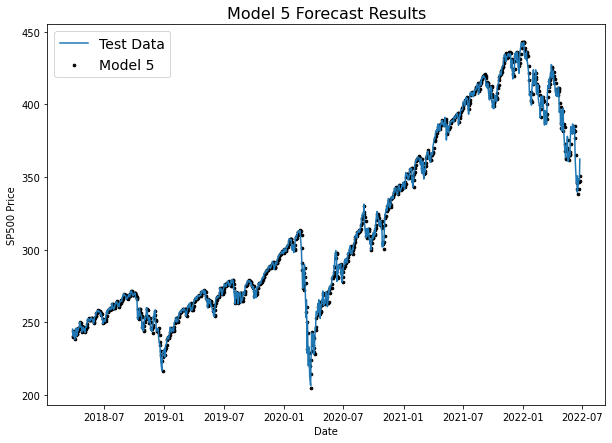

In [74]:
# Plot Model 5 Results

plt.figure(figsize=(10, 7))
plt.plot(X_test[-len(test_windows):], test_labels[:, 0], label="Test Data")
plt.scatter(X_test[-len(test_windows):], model_5_preds, label="Model 5", color="black",s=7)
plt.legend(fontsize=14);
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.title("Model 5 Forecast Results", fontsize=16);

In [75]:
# Compare different model results (w = window, h = horizon)
model_results = pd.DataFrame({"baseline": baseline_results,
                              "model_1_dense_w5_h1": model_1_results,
                              "model_2_dense_w10_h1": model_2_results,
                              "model_3_dense_w15_h5": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results}).T
model_results.head(6)

,mae,mse,rmse,mape,mase
baseline,2.714659,16.610561,4.075606,0.878246,1.001298
model_1_dense_w5_h1,2.694136,16.308317,4.038356,0.868883,0.993728
model_2_dense_w10_h1,2.761967,16.769011,4.094998,0.888508,1.018748
model_3_dense_w15_h5,4.690444,50.178020,5.306530,1.518309,1.731840
model_4_CONV1D,2.755701,16.753819,4.093143,0.886413,1.016436
model_5_LSTM,2.797927,17.368196,4.167517,0.895948,1.032011


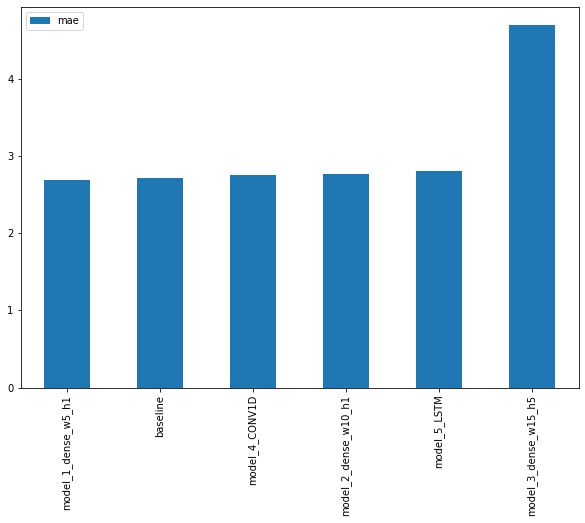

In [76]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");

##Checking Black Monday (October 19, 1987)

There was a 20% drop in the SP500 in a single day!  I want to test other areas of the data to see if sudden price drops can be predicted.

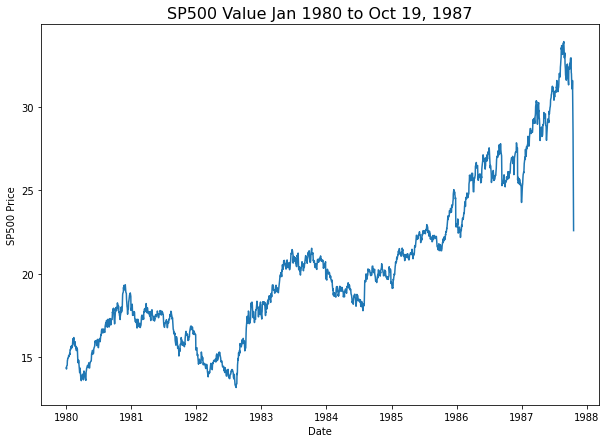

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np

black_monday_prices = prices[:1972]
black_monday_timesteps = timesteps[:1972]

plt.figure(figsize=(10, 7))
plt.plot(black_monday_timesteps, black_monday_prices)
plt.title("SP500 Value Jan 1980 to Oct 19, 1987", fontsize=16)
plt.xlabel("Date")
plt.ylabel("SP500 Price");

In [ ]:
# Create train and test sets to model Black Monday


HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 5 # use a week worth of timesteps to predict the horizon



full_windows, full_labels = make_windows(np.array(black_monday_prices), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)



(1770, 197, 1770, 197)

## Modeling Black Monday with Model 1

In [ ]:
# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
black_monday_model = tf.keras.models.clone_model(model_1)
black_monday_model._name = "Black_Monday_Model"
black_monday_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
black_monday_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(black_monday_model.name)])



INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments/Black_Monday_Model/assets
INFO:tensorflow:Assets written to: model_experiments

In [ ]:
# Evaluate model
black_monday_model.evaluate(X_test, y_test)



7/7 [==============================] - 0s 3ms/step - loss: 0.3163


0.31627023220062256

In [ ]:
# Load best model and evaluate on test data
black_monday_model = tf.keras.models.load_model("model_experiments/Black_Monday_Model/")
black_monday_model.evaluate(X_test, y_test)



7/7 [==============================] - 0s 5ms/step - loss: 0.2952


0.29515543580055237

In [ ]:
# Make predictions
black_monday_preds = make_preds(black_monday_model, X_test)
black_monday_preds[-10:]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33.06532 , 32.47424 , 32.123558, 31.731277, 31.374798, 31.187563,
       31.464804, 30.987757, 30.267721, 28.942236], dtype=float32)>

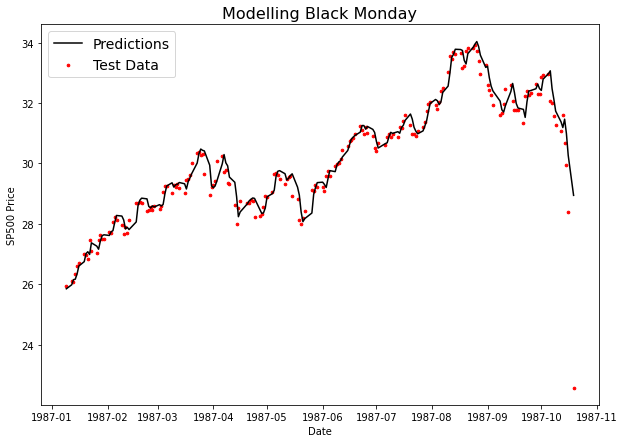

In [ ]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.scatter(black_monday_timesteps[-197:], black_monday_prices[-197:], label="Test Data",color="red", s=7)
plt.plot(black_monday_timesteps[-197:], black_monday_preds, label="Predictions",color="black")
plt.title("Modelling Black Monday", fontsize=16)
plt.xlabel("Date")
plt.ylabel("SP500 Price")
plt.legend(fontsize=14);

# 6. Conclusions

From observing the last few data points for modeling Black Monday, the model has poor predictive capabilities.  A model cannot predict anything in the future outside of the distribution of data used for training.  Therefore, larger, unexpected price movements upward or downward will likely never be part of a forecast.  These price prediction models are just highly optimized [technical analysis](https://en.wikipedia.org/wiki/Technical_analysis); this style of analysis has been debunked based upon the [efficient market hypothesis](https://en.wikipedia.org/wiki/Efficient-market_hypothesis).  Price predictions such as this are extremely difficult.  [A Random Walk Down Wall Street](https://www.amazon.com/Random-Walk-Down-Wall-Street/dp/0393358380/ref=sr_1_1?keywords=a+random+walk+down+wall+street&qid=1657044738&sprefix=a+random+walk%2Caps%2C182&sr=8-1) and the [Fama Portfolio ](https://www.amazon.com/Fama-Portfolio-Selected-Papers-Eugene/dp/022642684X/ref=sr_1_1?crid=KP8YKVA9VG96&keywords=the+fama+portfolio&qid=1657044728&sprefix=the+fama+portoflio%2Caps%2C178&sr=8-1) are great books dealing with this subject matter.  The models employed are no better -- and sometimes worse -- than using the previous day's closing price as your predicted price.